# Day 3 - Q-Learning for Optimized Trade Execution

In this tutorial, we are going to look at how the tabular Q-Learning algorithm can be used to solve the optimized trade execution problem.

This problem is well known in finance and can be described as follows:

1. A trader wants to liquidate its position in a stock. However, the trader cannot sell all of its shares right away. The reason is that there might not be enough buyers willing to exchange shares with the trader at the market price. Hence, the trader would obtain a poor average price for its position.
 
2. The trader has to split its trading in time according to a schedule. For our problem, the trader will have one full week of market (5 days) to trade. Each day, the trader must decide what quantity he will sell. At the end of the week, the trader must have sold all of his shares.

3. Every time the trader sells a block of shares, he will obtain a mean price lower than the market price. This can be described as a temporary impact that the trader has on the market due to limited liquidity. 

Finally, the trader is also risk averse. That means that he has a preference for selling shares earlier to avoid adverse price movement.

All the packages needed are included by default in Colab.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as mgrid
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

np.random.seed(123)

# Simulation environment

- Define the order duration as the time elapsed since the beginning of trading
- Define the volume to trade as the size of the the trader's initial position $V_{0}$
- Define the inventory remaining as the number of blocks of shares that the trader still has to sell.



$$ Reward_{t} = A_{t}\times(Price_{t} - Impact_{temp}) - \lambda_{risk} \times (V_{t}-A_{t})^2$$

$$ Impact_{temp} = \lambda_{impact}\times A_{t}^{1.5}$$

Where $A_{t}$ is the action taken by the trader or the number of shares sold at time t. Later, we will split the actions in blocks of shares to keep the problem small. We will try to sell 10 blocks (or lot) of 100 shares. Finally, $V_{t}$ is the remaining volume to trade at time t. We will use the following states:

$$ S_{t} = (t, V_{t})$$

# Simple market simulation using arithmetic Brownian Motion

In [0]:
class Simulator():
    
    LOT_SIZE = 100 # number of shares in one block
    
    def __init__(self,
                 init_price,
                 volume_to_trade,
                 horizon,
                 bm_drift,
                 bm_variance,
                 risk_averse_coeff,
                 temp_impact_coeff):
        
        
        # Initial price
        self.init_price = init_price
        
        # Brownian motion drift and variance
        self.bm_drift = bm_drift
        self.bm_variance = bm_variance
        
        # Penalty coefficients
        self.risk_averse_coeff = risk_averse_coeff
        self.temp_impact_coeff = temp_impact_coeff
        
        
        self.volume_to_trade = volume_to_trade
        self.horizon = horizon
        
        
        self.reset()
        
        
    def reset(self):
        
        
        self.price_t = self.init_price
        self.order_duration = 0
        self.total_volume_traded = 0

        self.price_history = []

        initial_state = [self.order_duration, self._remaining_inventory()]
            
        return initial_state
    
        
    def risk_penalty(self):

        penalty = self.risk_averse_coeff * (self._remaining_inventory()*self.LOT_SIZE)**2
            
        return penalty
    
    def temporary_impact(self, volume_traded):
        
        impact = self.temp_impact_coeff * (volume_traded*self.LOT_SIZE)**(1.5)
        
        return impact
    
        
    def step(self, volume_traded, dt):
        
        # add to volume traded
        self.total_volume_traded += volume_traded
        
        # update price history
        self.price_history.append(self.price_t) 
        
        # price movement from brownian motion until decision
        self.price_t += dt*self.bm_drift + np.sqrt(self.bm_variance*dt)*np.random.normal()
        
        
        # mean price obtained for the volume traded        
        mean_price_obtained = self.price_t - self.temporary_impact(volume_traded)
        
        
        # proceedings of the sell, minus the risk penalty
        reward = volume_traded * self.LOT_SIZE * mean_price_obtained - self.risk_penalty()
        
        
        # advance time
        self.order_duration += dt
        
        # create new state list
        new_state = [self.order_duration, self._remaining_inventory()]
        
        # if we have reached the trading horizon or sold all the volume to trade, we are done
        done = False
        
        if (self.order_duration >= self.horizon) or \
           (self.total_volume_traded >= self.volume_to_trade):
            
            done=True
    
        
        return reward, new_state, done
    
    
    def action_space(self):
        # we cannot sell more than the remaining inventory.
        return self._remaining_inventory() + 1
        
        
    def _remaining_inventory(self):
        
        return self.volume_to_trade - self.total_volume_traded
    
    

# The Q-Learning algorithm

In [0]:
class QLearning():
    
    def __init__(self,
                 horizon,
                 volume_to_trade,
                 exploration_epsilon,
                 discount_gamma,
                 step_size,
                 init_value=0):
    
        # initialize each state-action pair value
        self.Q_values = np.ones((horizon+1, volume_to_trade+1, volume_to_trade+1))*init_value
        
        
        self.exploration_epsilon = exploration_epsilon
        self.discount_gamma = discount_gamma
        self.step_size = step_size # also called the learning rate
        
        
    def update_Q_values(self,
                        last_order_duration,
                        last_remaining_inventory,
                        action_taken,
                        reward_obtained,
                        next_order_duration,
                        next_remaining_inventory):
        
        # maximum at the next state
        next_state_max = np.max(self.Q_values[next_order_duration,
                                              next_remaining_inventory])
        
        # current state-action value
        current_state_action_value =  self.Q_values[last_order_duration,
                                                    last_remaining_inventory,
                                                    action_taken]
        
        # difference between current state and sampled transition's value
        target = reward_obtained + self.discount_gamma*next_state_max - current_state_action_value

        # update to the relevant state-action pair
        self.Q_values[last_order_duration,
                      last_remaining_inventory,
                      action_taken] =  current_state_action_value + self.step_size*target
        
        
    def final_update_Q_values(self,
                              last_order_duration,
                              last_remaining_inventory,
                              action_taken,
                              reward_obtained):

        
        current_state_action_value =  self.Q_values[last_order_duration,
                                                    last_remaining_inventory,
                                                    action_taken]

            
        # at the final state, we don't transition anymore and need only the reward, no next state's maximum
        target = reward_obtained - current_state_action_value
        
        
        self.Q_values[last_order_duration,
                      last_remaining_inventory,
                      action_taken] =  current_state_action_value + self.step_size*target
    
    
        
    def epsilon_greedy(self, order_duration, remaining_inventory, action_space):
        
        # if random uniform (0,1) is smaller than epsilon, pick a random action
        if np.random.rand()<self.exploration_epsilon:
            action = np.random.randint(action_space)
        else:
            action = self.greedy(order_duration, remaining_inventory, action_space)
            
        return action
    

    def greedy(self, order_duration, remaining_inventory, action_space):
        
        # pick the best action within the action space
        action = np.argmax(self.Q_values[order_duration][remaining_inventory][:action_space])
        
        return action
    
    def decay_epsilon(self, decay):
        
        self.exploration_epsilon *= decay
        
    def decay_step_size(self, decay):
        
        self.step_size *= decay
        
    

In [0]:

# This function will play a full episode using the greedy action every time
def eval_agent(agent, sim, dt):
    
    done = False

    order_duration, remaining_inventory = sim.reset()
    
    # will return the optimal trading schedule according to the current Q-values
    inventory_hist = [remaining_inventory]
    rewards_obtained = []

    while not done:

        action = agent.greedy(order_duration, remaining_inventory, sim.action_space())
        reward, new_state, done = sim.step(action, dt)

        order_duration, remaining_inventory = new_state

        inventory_hist.append(remaining_inventory)
        rewards_obtained.append(reward)

    return rewards_obtained, inventory_hist

# Experiment parameters

In [0]:

init_price = 100. 
volume_to_trade = 10 # lots of 100 shares = 1000 shares
horizon = 5 # days

bm_drift = .00000 # zero drift for our example, but could be added
bm_variance = 0.5 # price variance of the browninan motion

risk_aversion = .005 # risk aversion penalty on the square of the number of shares remaining
temp_impact_coeff = 0.0005 # temporary impact coefficient

dt = 1 # timestep used for decision, 1 day


sim = Simulator(init_price,
                volume_to_trade,
                horizon,
                bm_drift,
                bm_variance,
                risk_aversion,
                temp_impact_coeff)


exploration_epsilon = .5
discount_gamma = 1. # we can use one since we are working in a finite horizon problem
step_size = 1. # initial learning rate
init_value = 0 # we initialize our Q-values to zero

agent = QLearning(horizon, volume_to_trade, exploration_epsilon, discount_gamma, step_size, init_value=init_value)

Text(0, 0.5, 'price')

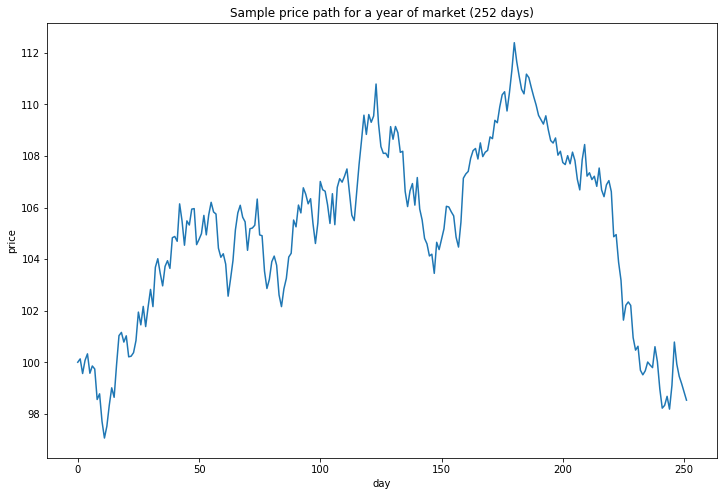

In [28]:
for i in range(252):
    sim.step(0, 1)

plt.figure(figsize=(12,8))
plt.title('Sample price path for a year of market (252 days)')
plt.plot(sim.price_history)
plt.xlabel('day')
plt.ylabel('price')

# Training loop

In [29]:


rolling_reward = -np.inf
rolling_rewards_hist = []


for episode in tqdm(range(10_000)):
    
    # Training the agent for one full episode
    
    order_duration, remaining_inventory = sim.reset() 

    done = False
    
    while not done:

        action_space = sim.action_space()
        action = agent.epsilon_greedy(order_duration, remaining_inventory, action_space)

        reward, new_state, done = sim.step(action, dt)


        if not done:

            agent.update_Q_values(order_duration, remaining_inventory, action, reward, new_state[0], new_state[1])
            order_duration, remaining_inventory = new_state

        else:

            agent.final_update_Q_values(order_duration, remaining_inventory, action, reward)
            agent.decay_step_size(0.9995)
            
    
    # Evaluate the agent's greedy policy for one episode
    
    rewards_obtained , _ = eval_agent(agent, sim, dt)
    
    if rolling_reward > -np.inf:
        rolling_reward = 0.99 * rolling_reward + .01 * np.sum(rewards_obtained)
    else:
        rolling_reward = np.sum(rewards_obtained)
    
    rolling_rewards_hist.append(rolling_reward)
    
    print(f'Episode {episode} - Rolling reward {rolling_reward} - Step size {agent.step_size}')
            
    

Episode 0 - Rolling reward 16655.309224797056 - Step size 0.9995
Episode 1 - Rolling reward 17361.045335873605 - Step size 0.9990002500000001
Episode 2 - Rolling reward 18059.341554209488 - Step size 0.9985007498750001
Episode 3 - Rolling reward 18747.736500359726 - Step size 0.9980014995000627
Episode 4 - Rolling reward 19428.225141190174 - Step size 0.9975024987503127
Episode 5 - Rolling reward 20104.125281837547 - Step size 0.9970037475009376
Episode 6 - Rolling reward 20786.480302707438 - Step size 0.9965052456271871
Episode 7 - Rolling reward 21447.426898780715 - Step size 0.9960069930043736
Episode 8 - Rolling reward 22107.58681240188 - Step size 0.9955089895078715
Episode 9 - Rolling reward 22764.86417154342 - Step size 0.9950112350131176
Episode 10 - Rolling reward 23404.245022371986 - Step size 0.9945137293956111
Episode 11 - Rolling reward 24041.126917452762 - Step size 0.9940164725309134
Episode 12 - Rolling reward 24669.944930377056 - Step size 0.993519464294648
Episode 13 

# Visualization

(0, 5000)

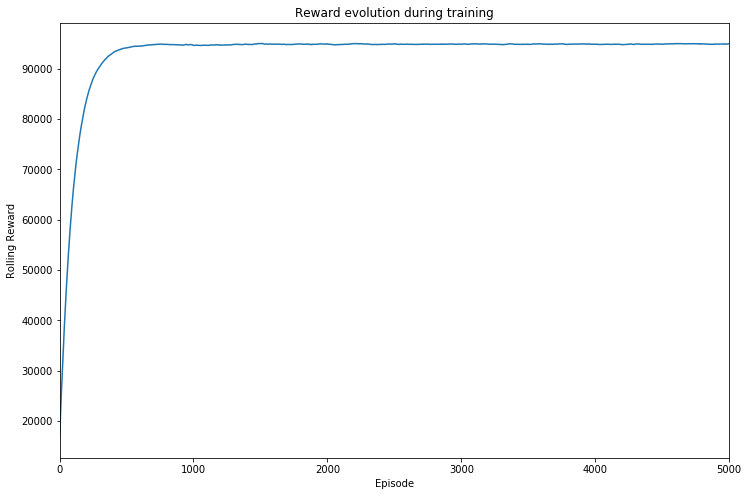

In [30]:
plt.figure(figsize=(12,8))
plt.title('Reward evolution during training')
plt.xlabel('Episode')
plt.ylabel('Rolling Reward')
plt.plot(rolling_rewards_hist)
plt.xlim((0, 5000))

In [0]:
_, inventory_hist = eval_agent(agent, sim, dt)

Text(0.5, 0, 'day')

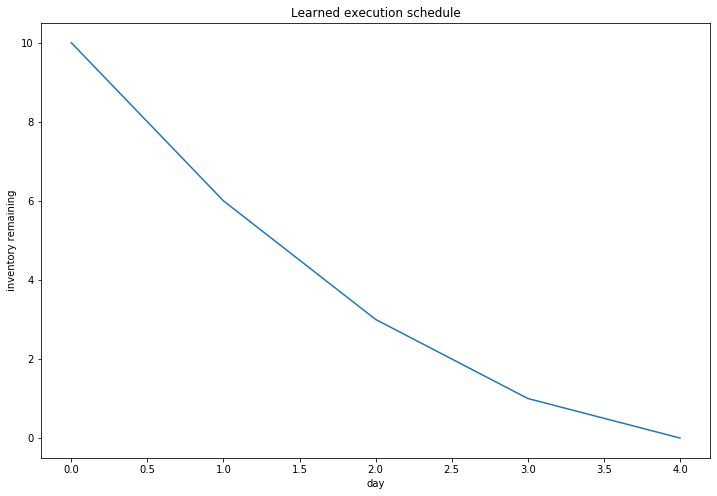

In [32]:
plt.figure(figsize=(12,8))

plt.title('Learned execution schedule')
plt.plot(inventory_hist)
plt.ylabel('inventory remaining')
plt.xlabel('day')


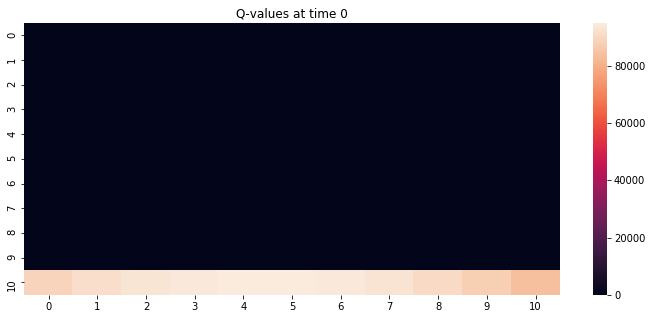

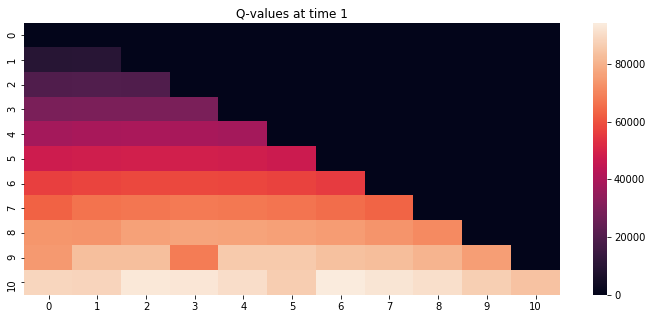

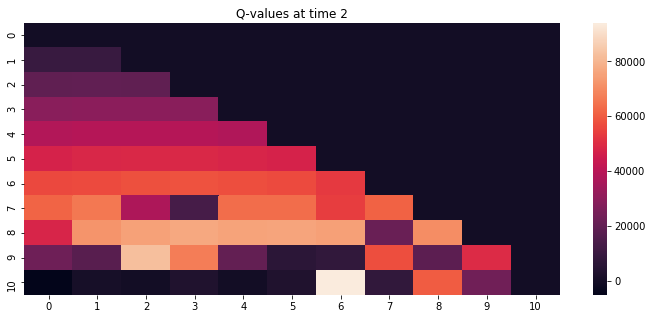

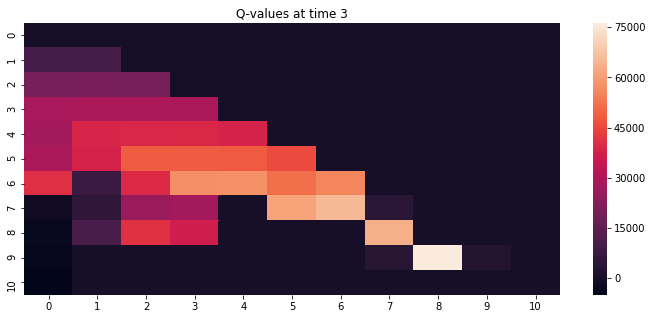

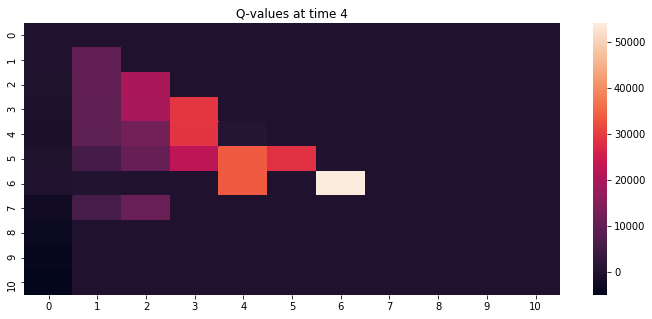

In [33]:
for i in range(horizon):
    plt.figure(figsize=(12,5))
    plt.title('Q-values at time {}'.format(i))
    plt.xlabel('Number of blocks sold')
    plt.ylabel('Inventory remaining')
    sns.heatmap(agent.Q_values[i],)
    plt.show()